In [2]:
import numpy as np
import random
import pandas as pd 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math,time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import yfinance as yf

## Fetch price series of both assets in *optimal pair (found in previous sections)
## Calculuate spread of assets and normalise data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


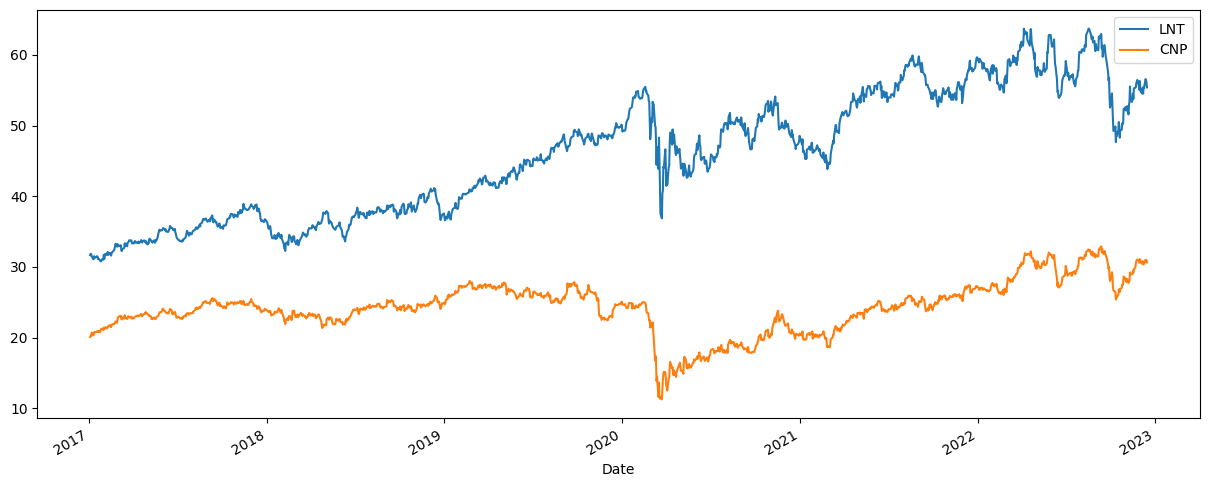

In [3]:
Asset1 = yf.download('LNT', start='2017-01-01', end='2022-12-16')
Asset1['Adj Close'].plot(figsize=(15,6),label='LNT')
Asset2 = yf.download('CNP', start='2017-01-01', end='2022-12-16')
Asset2['Adj Close'].plot(figsize=(15,6),label='CNP')
plt.legend()
plt.show()

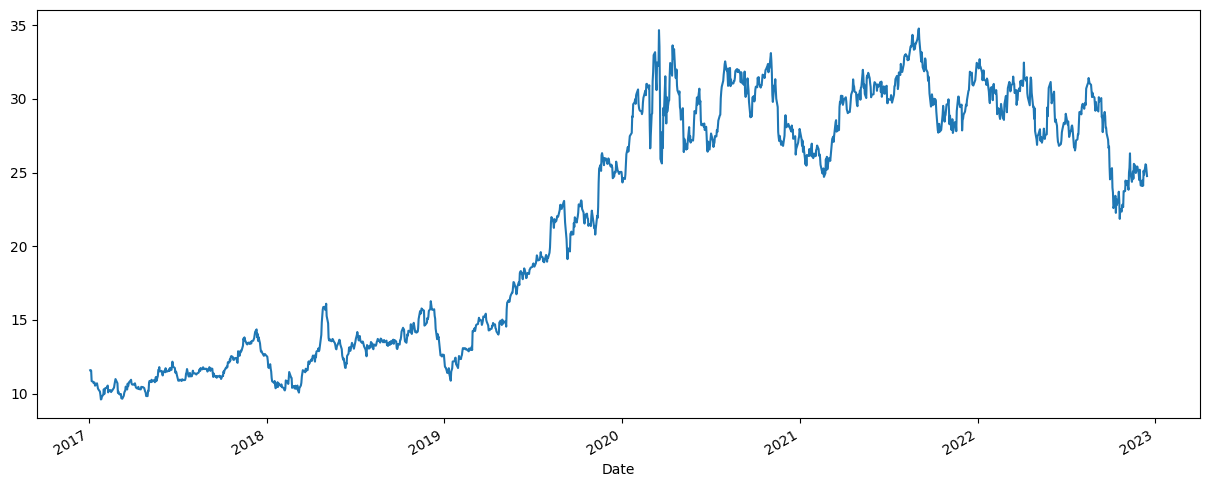

In [4]:
spread = np.abs(Asset1['Adj Close'] - Asset2['Adj Close'])
spread.plot(figsize=(15,6))
plt.show()

In [5]:
dates = pd.date_range('2017-01-03','2022-12-16',freq='B')
df1=pd.DataFrame(index=dates)
spread_df=df1.join(spread)
spread_df

,Adj Close
2017-01-03,11.585997
2017-01-04,11.598379
2017-01-05,11.556639
2017-01-06,10.848814
2017-01-09,10.806629
...,...
2022-12-12,25.559999
2022-12-13,25.509998
2022-12-14,25.099998
2022-12-15,24.760000


In [6]:
spread_df_norm=spread_df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
spread_df_norm['Adj Close'] = scaler.fit_transform(spread_df_norm['Adj Close'].values.reshape(-1,1))
spread_df_norm.head()

,Adj Close
2017-01-03,-0.842742
2017-01-04,-0.841758
2017-01-05,-0.845075
2017-01-06,-0.901336
2017-01-09,-0.904689


## Establish training validation testing split
## Define architecture of LSTM model
## Initialise LSTM model

In [7]:
def data(asset, look_back):
    asset = asset
    data = []
    
    #All combinations of data given look back value
    for i in range(len(asset) - look_back): 
        data.append(asset[i: i + look_back])
    
    data = np.array(data);
    test_len = int(np.round(0.25*data.shape[0]))
    train_val_len = data.shape[0] - (test_len)
    val_len = int(np.round(0.3*train_val_len))
    train_len= data.shape[0] - (val_len)-test_len

    x_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    
    x_val = data[train_len:train_len+val_len,:-1,:]
    y_val = data[train_len:train_len+val_len,-1,:]
    
    x_test = data[train_len+val_len:,:-1]
    y_test = data[train_len+val_len:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [63]:
look_back = 2 # choose sequence length
x_train, y_train,x_val,y_val, x_test, y_test = data(spread_df_norm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (815, 1, 1)
y_train.shape =  (815, 1)
x_val.shape =  (349, 1, 1)
y_val.shape =  (349, 1)
x_test.shape =  (388, 1, 1)
y_test.shape =  (388, 1)


In [64]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [65]:
y_train.size(),x_train.size(),y_val.size(),x_val.size(),y_test.size(),x_test.size() #confirm dimensions so can set the correct parameters for neural network below


(torch.Size([815, 1]),
 torch.Size([815, 1, 1]),
 torch.Size([349, 1]),
 torch.Size([349, 1, 1]),
 torch.Size([388, 1]),
 torch.Size([388, 1, 1]))

In [66]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() #make hidden state 0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #detach so can do truncated backprop 
        out = self.fc(out[:, -1, :]) 
        return out

## Hyperparamters chosen to minimise loss function
### *chose Adam optimiser as it converged most effectively

In [67]:
input_dim = 1
hidden_dim = 10
num_layers = 5
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 10, num_layers=5, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


## Fit model to training set 
### * 2000 epochs likely not necessary somewhere between 1000-1500 likely optimal for my particular set of data

In [68]:
num_epochs = 2000
hist = np.zeros(num_epochs)
seq_dim =look_back-1  

for t in range(num_epochs):
    y_train_prediction = model(x_train) #forward pass

    loss_ = loss(y_train_prediction, y_train)
    if t % 200 == 0 and t !=0:
        print("Epoch", t, "MSE: ", loss_.item())
    hist[t] = loss_.item()
    optimiser.zero_grad()
    loss_.backward() #backward pass
    optimiser.step() #update parameters

Epoch 200 MSE:  0.07015913724899292
Epoch 400 MSE:  0.009576699696481228
Epoch 600 MSE:  0.001629182486794889
Epoch 800 MSE:  0.0006238750647753477
Epoch 1000 MSE:  0.0005776885082013905
Epoch 1200 MSE:  0.0005612857057712972
Epoch 1400 MSE:  0.000552401936147362
Epoch 1600 MSE:  0.0005470823962241411
Epoch 1800 MSE:  0.0005438168882392347


In [69]:
y_val_prediction=model(x_val)
y_test_prediction = model(x_test)

y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_val_prediction = scaler.inverse_transform(y_val_prediction.detach().numpy())
y_val = scaler.inverse_transform(y_val.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

#root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train RMSE Score:',trainScore)
valScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_prediction[:,0]))
print('Val RMSE Score:',valScore)
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test RMSE Score:', testScore)

Train RMSE Score: 0.29283516699425466
Val RMSE Score: 0.8541067769213968
Test RMSE Score: 0.8737870733230025


## Visualise forecasted verses actual spread of training validation and testing sets

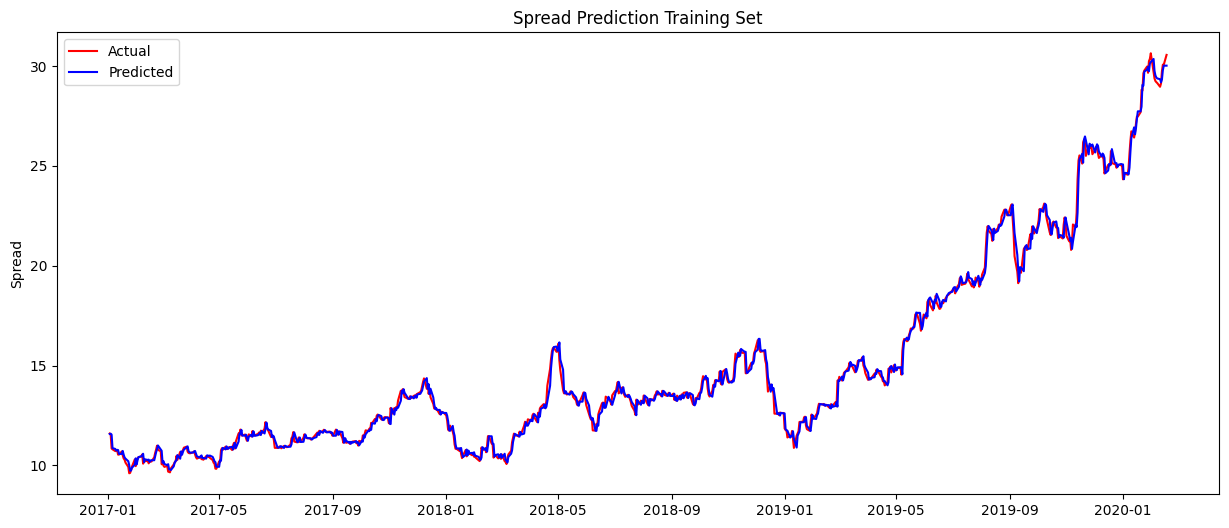

In [87]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[:len(y_train)].index, y_train, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[:len(y_train)].index, y_train_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Training Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

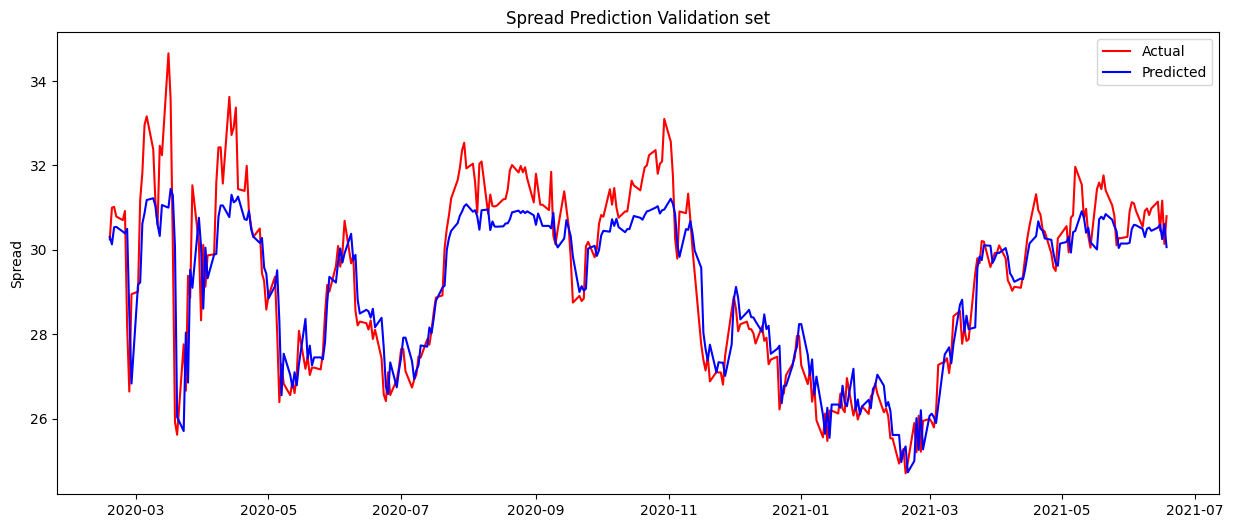

In [88]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Validation set')
plt.ylabel('Spread')
plt.legend()
plt.show()

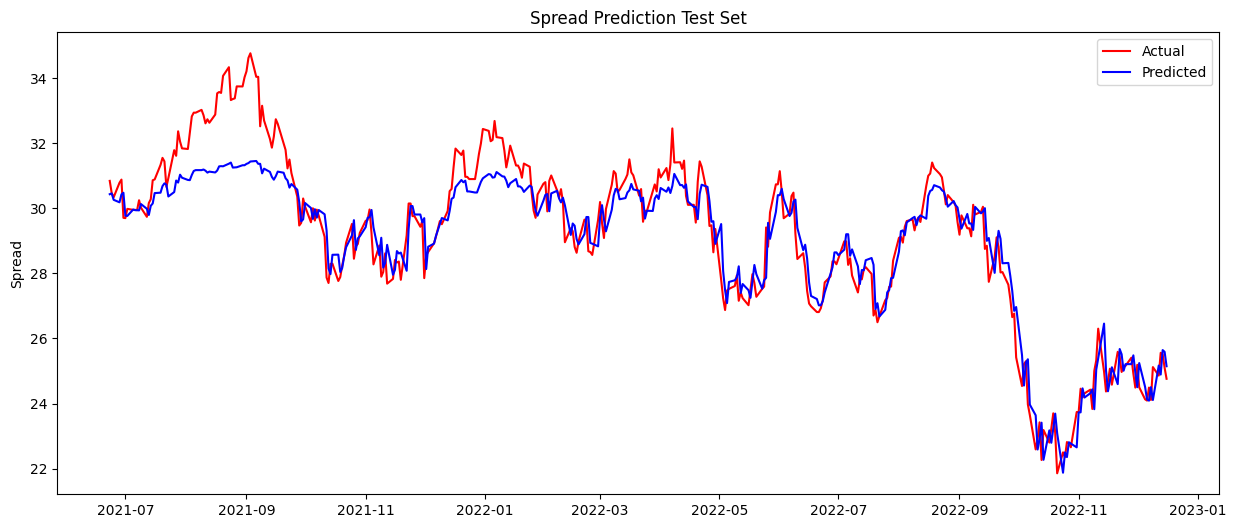

In [89]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Test Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

## Find optimal threshold - decile method


In [73]:
ydf=spread_df[0:len(y_train)].fillna(method='ffill')
y_perc_change=ydf.pct_change().fillna(method='bfill')['Adj Close']
negchange=[]
poschange=[]
for i in range(0,len(y_perc_change)):
    if y_perc_change[i]>= 0:
        poschange.append(y_perc_change[i])
    else:
        negchange.append(y_perc_change[i])

In [103]:
pospercentile=np.percentile(poschange, np.arange(0, 100, 5))
negpercentile=np.percentile(negchange, np.arange(0, 100, 5))
top_decile_threshold = pospercentile[-2]
bottom_decile_threshold = negpercentile[2]

In [104]:
print('Top decile threshold:',top_decile_threshold,'Bottom decile threshold:',bottom_decile_threshold)

Top decile threshold: 0.031868448847537104 Bottom decile threshold: -0.030564149364659


## Test decile method on the validation set
## Generate trade signal and do a backtest to see returns and metric 
### * will compare with quintile method in next part

In [91]:
#Percent change between forecast spread at time t+1 and actual spread at time 2
def percentage_change(col1,col2):
    return ((col2 - col1) / col1) 
perc_change=[]
for i in range(0,len(y_val)-1):
    
    percΔ=percentage_change(y_val[i],y_val_prediction[i+1])
    perc_change.append(percΔ)
    
perc=np.array(perc_change)


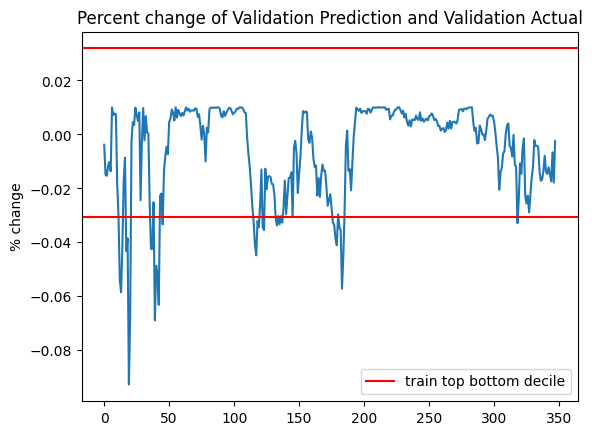

In [105]:
plt.plot(perc)
plt.axhline(y = bottom_decile_threshold, color = 'r', linestyle = '-',label='train top bottom decile')
plt.axhline(y = top_decile_threshold, color = 'r', linestyle = '-')
plt.title('Percent change of Validation Prediction and Validation Actual')
plt.ylabel('% change')
plt.legend()
plt.show()

## For this particular case our percent change never hits the top quintile or decile, but does intersect the bottom quintile and decile
## This means every transaction is either shorting the spread or closing an open trade

In [78]:
below=[]
above=[]
for i in range(0,len(perc)):
    if perc[i]<= bottom_decile_threshold:
        below.append(i)
    elif perc[i] >= top_decile_threshold:
        above.append(i)

In [79]:
x=[]
y=[]
val_spread=spread_df[len(y_train):len(y_train)+len(y_val)]
for i in range(0,len(below)):
    x.append(val_spread.index[below[i]])
    y.append(val_spread['Adj Close'][below[i]])

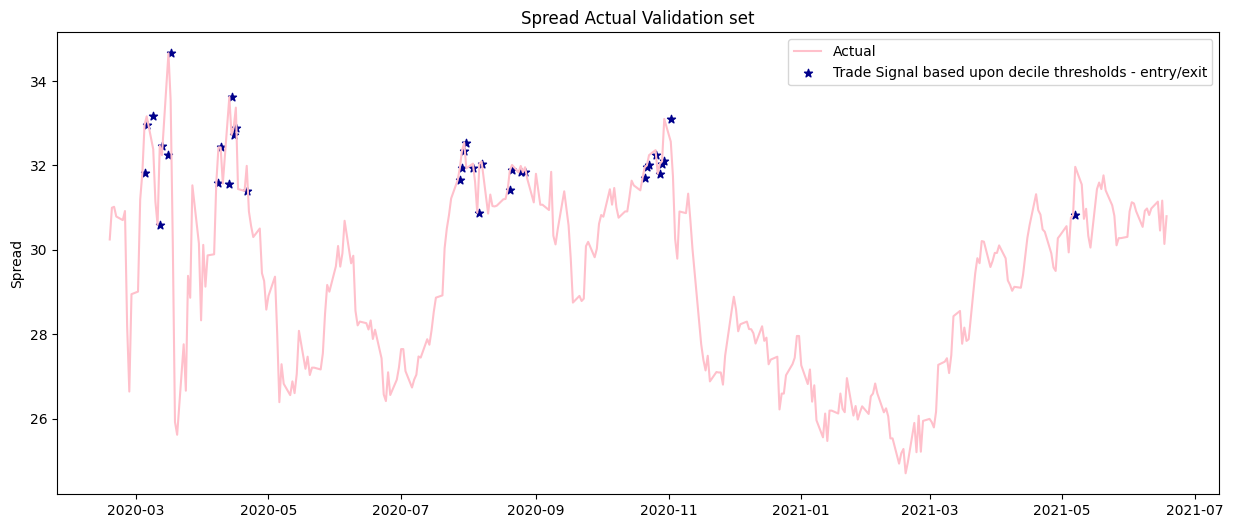

In [80]:
#Decile method
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'pink', label = 'Actual')
plt.scatter(x, y, marker="*", color="darkblue",label='Trade Signal based upon decile thresholds - entry/exit')
plt.title('Spread Actual Validation set')
plt.ylabel('Spread')
plt.legend()
plt.show()

## To short the spread we will go long one asset and short the other depending on the ratio. When the ration of asset1:asset 2 is larger than its mean AND the percentage change of the spread has gone above or below our thresholds, we consider asset 1 to be over valued with respect to asset b and thus we will short asset 1 and long asset 2. When the ratio of asset1:asset2 is smaller than its mean we consider asset 2 over valued with respect to asset 1 and we will short asset 2 and long asset1. We keep these trades until our spread percent change reverts to within the bounds of our upper and lower threshold

In [81]:
val_spread=spread_df[len(y_train):len(y_train)+len(y_val)]
ratio = np.abs(Asset1['Adj Close']/Asset2['Adj Close'])
x_r=[]
y_r=[]
val_ratio=ratio[len(y_train):len(y_train)+len(y_val)]
for i in range(0,len(below)):
    x_r.append(val_ratio.index[below[i]])
    y_r.append(val_ratio[below[i]])
val_ratio=ratio[len(y_train):len(y_train)+len(y_val)]

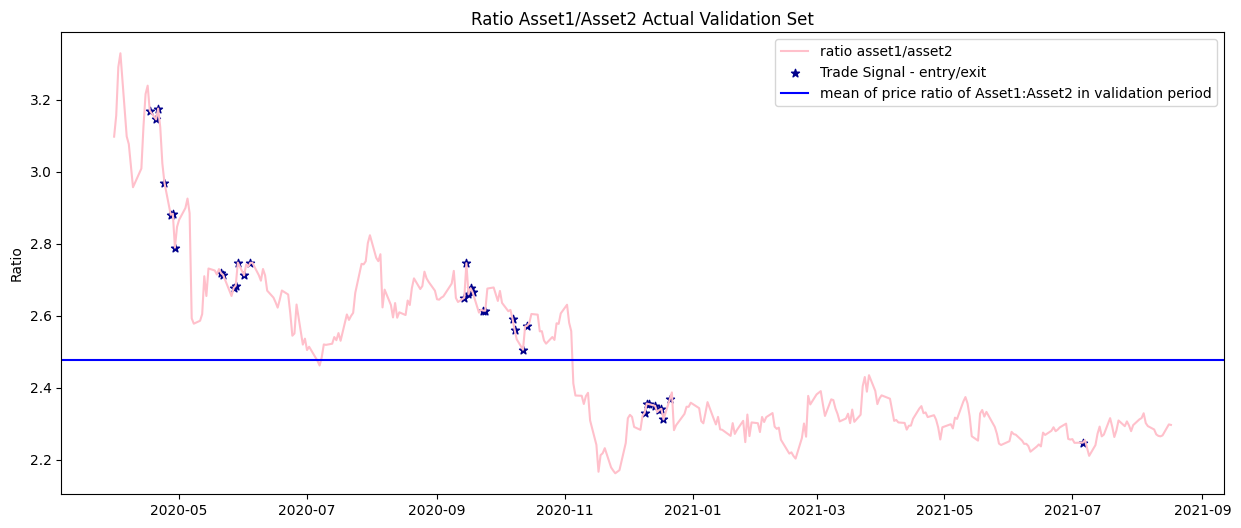

In [94]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(ratio[len(y_train):len(y_train)+len(y_val)].index, ratio[len(y_train):len(y_train)+len(y_val)], color = 'pink', label = 'ratio asset1/asset2')
plt.scatter(x_r, y_r, marker="*", color="darkblue",label='Trade Signal - entry/exit')
plt.axhline(y = ratio[len(y_train):len(y_train)+len(y_val)].mean(), color = 'b', linestyle = '-',label='mean of price ratio of Asset1:Asset2 in validation period')
plt.title('Ratio Asset1/Asset2 Actual Validation Set')
plt.ylabel('Ratio')
plt.legend()
plt.show()

In [95]:
#asset 1 overvalued when ratio above mean -> sell asset 1 long asset 2
#asset 2 overvalue when ratio below mean -> sell asset2 long asset2
#calculate positions
positions=pd.DataFrame(index=ratio[len(y_train):len(y_train)+len(y_val)].index, columns = ['Asset1','Asset2','l/s spread'])
position_open=False
for date in range(0,len(perc)):
    
    #if no position is open
    if position_open==False:
        if perc[date] <= bottom_decile_threshold:
            position_open = True
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [-1,1,'short spread']
            else:
                positions.loc[val_ratio.index[date]] = [1,-1,'short spread']
        else:
            position_open = False
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [0,0,'no change']
            else:
                positions.loc[val_ratio.index[date]] = [0,0,'no change']
    # if position is open            
    if position_open == True:
        if perc[date] <= bottom_decile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [-1,1,'no change']
            else:
                positions.loc[val_ratio.index[date]] = [1,-1,'no change']
        else:
            position_open=False
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [0,0,'close trade']
            else:
                positions.loc[val_ratio.index[date]] = [0,0,'close trade']    

## Calculate log returns of assets and find the algorithms returns for validation set. Compare our algorithm returns with the appropriate index based on cluster (in this case we are showing an optimal pair from the Utility cluster, so I will use VPU Vanguard utility Index etf as a comparison)

In [98]:
Asset1 = yf.download('LNT', start='2017-01-01', end='2022-12-16')
Asset1['log_ret1'] = np.log(Asset1['Adj Close']) - np.log(Asset1['Adj Close'].shift(1))
logret1=Asset1['log_ret1'][len(y_train):len(y_train)+len(y_val)]
logret1c=logret1.cumsum()

Asset2 = yf.download('CNP', start='2017-01-01', end='2022-12-16')
Asset2['log_ret2'] = np.log(Asset2['Adj Close']) - np.log(Asset2['Adj Close'].shift(1))
logret2=Asset2['log_ret2'][len(y_train):len(y_train)+len(y_val)]
logret2c=logret2.cumsum()
p=positions.join(logret1)
z=p.join(logret2).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [99]:
# calculate returns
algo_ret = (z['Asset1']*z['log_ret1'].shift()+z['Asset2']*z['log_ret2'].shift())

[*********************100%***********************]  1 of 1 completed


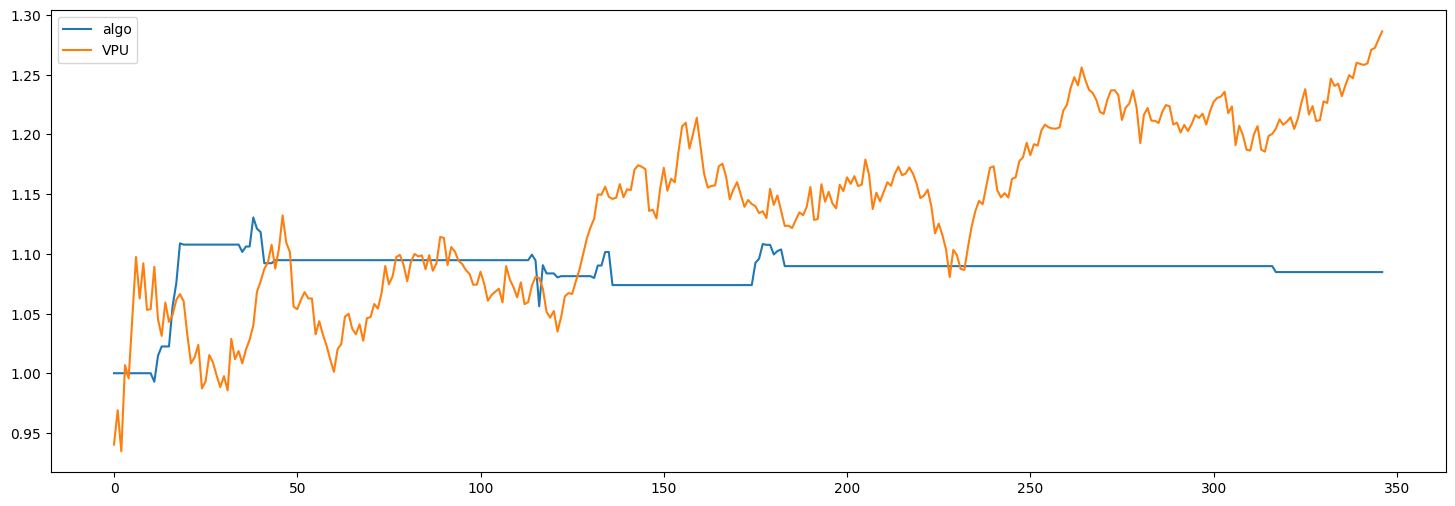

In [102]:
algo_ret=algo_ret.dropna()
returns=[]
for i in range(0,len(algo_ret)):
    returns.append(np.exp(algo_ret[i])-1)

index_price = yf.download('VPU', start=Asset1[len(y_train):len(y_train)+len(y_val)].index[0], end=Asset1[len(y_train):len(y_train)+len(y_val)].index[-1])
index_price = index_price['Adj Close']
index_ret =index_price.pct_change().dropna()

plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(np.array(returns)+1), label='algo')
plt.plot(np.nancumprod(index_ret + 1), label='VPU')
plt.legend()
plt.show()

## Algo for this particular pair did not beat the benchmark index for validation period, we will test quintile threshold in next section, and ideally create a portfolio of optimal pairs and run the algo on entire portfolio (not just one pair)